# Electricity Consumption Analysis

This notebook integrates the analysis of electricity demand, pricing, and weather data over multiple years. We load and clean the data from several sources, perform feature engineering and exploratory analysis, and then build forecasting models using Random Forest and XGBoost.

## Table of Contents

1. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
2. [Data Preprocessing and Feature Engineering](#Data-Preprocessing-and-Feature-Engineering)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Model Building and Forecasting](#Model-Building-and-Forecasting)
5. [Conclusions](#Conclusions)

## Data Loading and Cleaning

We begin by loading two datasets containing historic electricity demand. We standardise column names, convert date columns, inspect missing data, and perform initial cleaning by dropping or interpolating problematic columns.

,Missing Percentage
nsl_flow,62.77%
eleclink_flow,62.77%
scottish_transfer,87.88%
viking_flow,87.88%
greenlink_flow,94.16%


/var/folders/24/8pzn85m10vqgk7r1c979brn00000gn/T/ipykernel_92183/2924952172.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.values, y=missing_values.index, palette="YlOrRd")


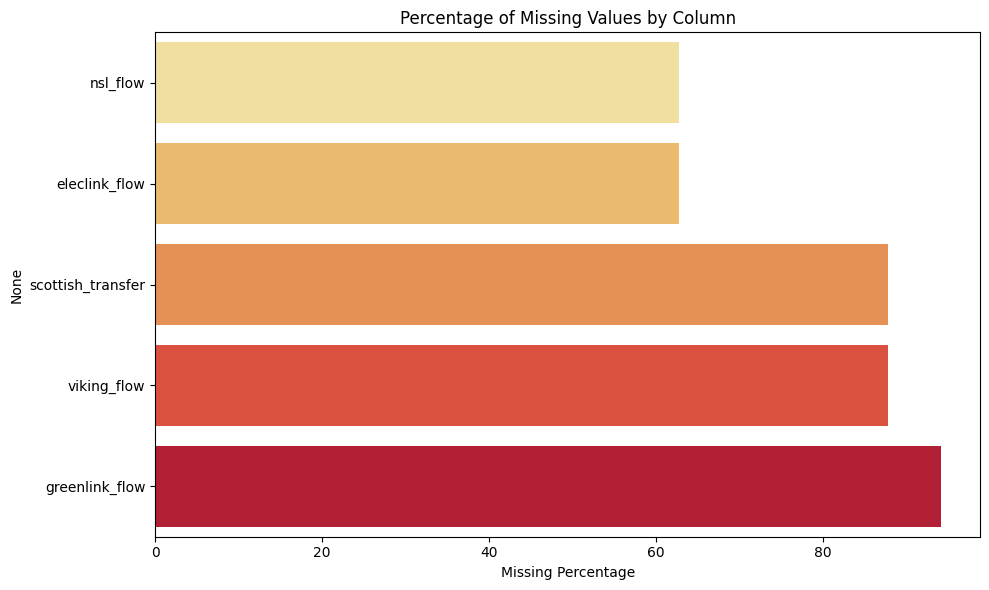

,Remaining Missing Values
unnamed:_0,0
settlement_date,0
settlement_period,0
nd,0
tsd,0
england_wales_demand,0
embedded_wind_generation,0
embedded_wind_capacity,0
embedded_solar_generation,0
embedded_solar_capacity,0


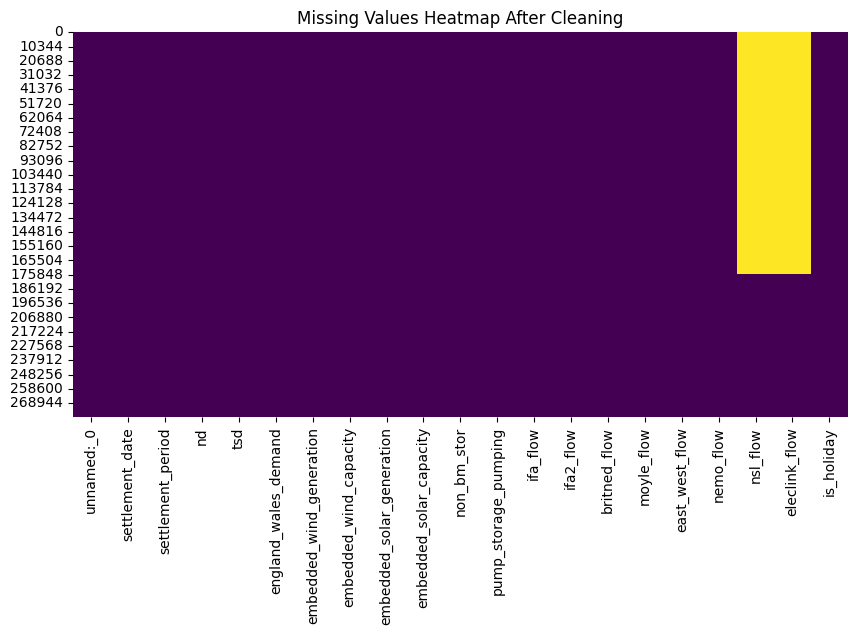

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define file paths
combined_data_path = "historic_demand_2009_2024.csv"
yearly_data_path = "historic_demand_year_2009.csv"

# Load datasets
df_combined = pd.read_csv(combined_data_path)
df_yearly = pd.read_csv(yearly_data_path)

# Standardize column names
df_combined.columns = df_combined.columns.str.lower().str.replace(" ", "_")
df_yearly.columns = df_yearly.columns.str.lower().str.replace(" ", "_")

# Convert settlement_date columns to datetime
df_combined['settlement_date'] = pd.to_datetime(df_combined['settlement_date'])
df_yearly['settlement_date'] = pd.to_datetime(df_yearly['settlement_date'], format="%d-%b-%Y")

# Check percentage of missing values for df_combined
missing_values = df_combined.isnull().sum() / len(df_combined) * 100
missing_values = missing_values[missing_values > 0]
missing_df = missing_values.to_frame(name="Missing Percentage")
display(missing_df.style.format("{:.2f}%").background_gradient(cmap='Reds'))

# Visualize missing values
plt.figure(figsize=(10, max(6, len(missing_values)*0.5)))
sns.barplot(x=missing_values.values, y=missing_values.index, palette="YlOrRd")
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Missing Percentage')
plt.tight_layout()
plt.show()

# Drop columns with excessive missing data
cols_to_drop = ['scottish_transfer', 'viking_flow', 'greenlink_flow']
df_combined_cleaned = df_combined.drop(columns=cols_to_drop, errors='ignore')

# Interpolate missing values for specific columns
for col in ['nsl_flow', 'eleclink_flow']:
    if col in df_combined_cleaned.columns:
        df_combined_cleaned[col] = df_combined_cleaned[col].interpolate(method='linear')

# Verify missing values are handled
remaining_missing = df_combined_cleaned.isnull().sum()
display(remaining_missing.to_frame(name="Remaining Missing Values"))

# Plot a heatmap of missing values
plt.figure(figsize=(10, 5))
sns.heatmap(df_combined_cleaned.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap After Cleaning")
plt.show()

## Data Preprocessing and Feature Engineering

In this section we extract time-based features from the cleaned demand data, create rolling averages, and add a categorical indicator for peak versus off-peak hours. We then merge in external datasets containing electricity prices and weather information.

In [2]:
# Extract time-based features from the demand data
df_combined_cleaned['year'] = df_combined_cleaned['settlement_date'].dt.year
df_combined_cleaned['month'] = df_combined_cleaned['settlement_date'].dt.month
df_combined_cleaned['day'] = df_combined_cleaned['settlement_date'].dt.day
df_combined_cleaned['hour'] = df_combined_cleaned['settlement_period'] // 2  # Half-hourly periods
df_combined_cleaned['weekday'] = df_combined_cleaned['settlement_date'].dt.weekday
df_combined_cleaned['is_weekend'] = df_combined_cleaned['weekday'].isin([5, 6]).astype(int)

# Define a function to create a 'season' feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_combined_cleaned['season'] = df_combined_cleaned['month'].apply(get_season)

# Create rolling averages for demand
df_combined_cleaned['demand_24h_avg'] = df_combined_cleaned['england_wales_demand'].rolling(window=48, min_periods=1).mean()
df_combined_cleaned['demand_7d_avg'] = df_combined_cleaned['england_wales_demand'].rolling(window=48*7, min_periods=1).mean()

# Define peak vs. off-peak hours
def peak_offpeak(hour):
    return "Peak" if 7 <= hour <= 22 else "Off-Peak"

df_combined_cleaned['peak_offpeak'] = df_combined_cleaned['hour'].apply(peak_offpeak)

# Re-display a sample of the updated dataset
display(df_combined_cleaned.head())

,unnamed:_0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,year,month,day,hour,weekday,is_weekend,season,demand_24h_avg,demand_7d_avg,peak_offpeak
0,0,2009-01-01,1,37910,38704,33939,54,1403,0,0,...,2009,1,1,0,3,0,Winter,33939.000000,33939.000000,Off-Peak
1,1,2009-01-01,2,38047,38964,34072,53,1403,0,0,...,2009,1,1,1,3,0,Winter,34005.500000,34005.500000,Off-Peak
2,2,2009-01-01,3,37380,38651,33615,53,1403,0,0,...,2009,1,1,1,3,0,Winter,33875.333333,33875.333333,Off-Peak
3,3,2009-01-01,4,36426,37775,32526,50,1403,0,0,...,2009,1,1,2,3,0,Winter,33538.000000,33538.000000,Off-Peak
4,4,2009-01-01,5,35687,37298,31877,50,1403,0,0,...,2009,1,1,2,3,0,Winter,33205.800000,33205.800000,Off-Peak


### Merge with Electricity Prices Dataset

Next, we load the 2023 electricity prices dataset from ONS, clean and reformat it, and merge it with our demand data for the year 2023.

In [4]:
# Load ONS electricity prices data
ons_data_path = "electricitypricesdataset211223.xlsx"

# Read the correct sheet containing data
df_ons = pd.read_excel(ons_data_path, sheet_name=0)
df_ons_data = pd.read_excel(ons_data_path, sheet_name="Data")

# Clean and rename columns
df_ons_data = df_ons_data.iloc[2:].rename(columns={
    "System Price of electricity, pence per kilowatt-hour ": "date",
    "Unnamed: 1": "daily_price",
    "Unnamed: 2": "weekly_avg_price"
})
df_ons_data.rename(columns={"System Price of electricity, pence per kilowatt-hour ": "date"}, inplace=True)

# Drop rows where 'date' equals the string "Date" (or any non-date value)
df_ons_data = df_ons_data[df_ons_data['date'] != "Date"]

# Now convert the 'date' column to datetime format
df_ons_data['date'] = pd.to_datetime(df_ons_data['date'], errors='coerce')

# Drop rows where the conversion failed (NaT values)
df_ons_data = df_ons_data.dropna(subset=["date"])

# Keep only the relevant columns
df_ons_data = df_ons_data[['date', 'daily_price', 'weekly_avg_price']]

# Filter for 2023 data and merge with demand data
df_ons_2023 = df_ons_data[df_ons_data['date'].dt.year == 2023]
df_demand_2023 = df_combined_cleaned[df_combined_cleaned['year'] == 2023].copy()
df_demand_2023 = df_demand_2023.merge(df_ons_2023, left_on='settlement_date', right_on='date', how='left')
df_demand_2023.drop(columns=['date'], inplace=True)

display(df_demand_2023.head())

,unnamed:_0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,day,hour,weekday,is_weekend,season,demand_24h_avg,demand_7d_avg,peak_offpeak,daily_price,weekly_avg_price
0,245424,2023-01-01,1,21043,24680,18995,2815,6545,0,15005,...,1,0,6,1,Winter,23222.812500,23071.238095,Off-Peak,12.896896,9.383749
1,245425,2023-01-01,2,21756,25289,19730,2793,6545,0,15005,...,1,1,6,1,Winter,23209.750000,23073.717262,Off-Peak,12.896896,9.383749
2,245426,2023-01-01,3,21348,25269,19327,2773,6545,0,15005,...,1,1,6,1,Winter,23196.958333,23076.068452,Off-Peak,12.896896,9.383749
3,245427,2023-01-01,4,20586,24574,18589,2753,6545,0,15005,...,1,2,6,1,Winter,23180.500000,23077.678571,Off-Peak,12.896896,9.383749
4,245428,2023-01-01,5,19781,24135,17806,2712,6545,0,15005,...,1,2,6,1,Winter,23160.166667,23078.232143,Off-Peak,12.896896,9.383749


### Merge with Weather Data

We load the London weather dataset, clean and reformat the dates, fill missing values, and merge with our demand and prices dataset.

In [5]:
# Load London weather data
weather_data_path = "london0_23_weather_data.csv"
df_weather = pd.read_csv(weather_data_path)

# Create a proper date column (assuming daily data starting from 2000-01-01) and filter for 2023
df_weather['date'] = pd.date_range(start="2000-01-01", periods=len(df_weather), freq='D')
df_weather_2023 = df_weather[df_weather['date'].dt.year == 2023].copy()

# Fill missing values
df_weather_2023.fillna(method='bfill', inplace=True)
df_weather_2023.fillna(method='ffill', inplace=True)

# Ensure a full date range for 2023
full_date_range = pd.DataFrame({'date': pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')})
df_weather_2023 = full_date_range.merge(df_weather_2023, on='date', how='left')
df_weather_2023.fillna(method='bfill', inplace=True)
df_weather_2023.fillna(method='ffill', inplace=True)

# Merge weather data with demand and prices data
df_merged_2023 = df_demand_2023.merge(df_weather_2023, left_on='settlement_date', right_on='date', how='left')
df_merged_2023.drop(columns=['date'], inplace=True)

display(df_merged_2023.head())

,unnamed:_0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,245424,2023-01-01,1,21043,24680,18995,2815,6545,0,15005,...,9.3,7.8,10.8,2.0,NaN,210.0,17.8,44.5,1008.4,NaN
1,245425,2023-01-01,2,21756,25289,19730,2793,6545,0,15005,...,9.3,7.8,10.8,2.0,NaN,210.0,17.8,44.5,1008.4,NaN
2,245426,2023-01-01,3,21348,25269,19327,2773,6545,0,15005,...,9.3,7.8,10.8,2.0,NaN,210.0,17.8,44.5,1008.4,NaN
3,245427,2023-01-01,4,20586,24574,18589,2753,6545,0,15005,...,9.3,7.8,10.8,2.0,NaN,210.0,17.8,44.5,1008.4,NaN
4,245428,2023-01-01,5,19781,24135,17806,2712,6545,0,15005,...,9.3,7.8,10.8,2.0,NaN,210.0,17.8,44.5,1008.4,NaN


## Exploratory Data Analysis

We now visualize the key trends and relationships in the data. The following plots explore energy demand trends over time, differences during peak/off-peak hours, correlations among variables, seasonal effects, and the impact of weather factors on demand.

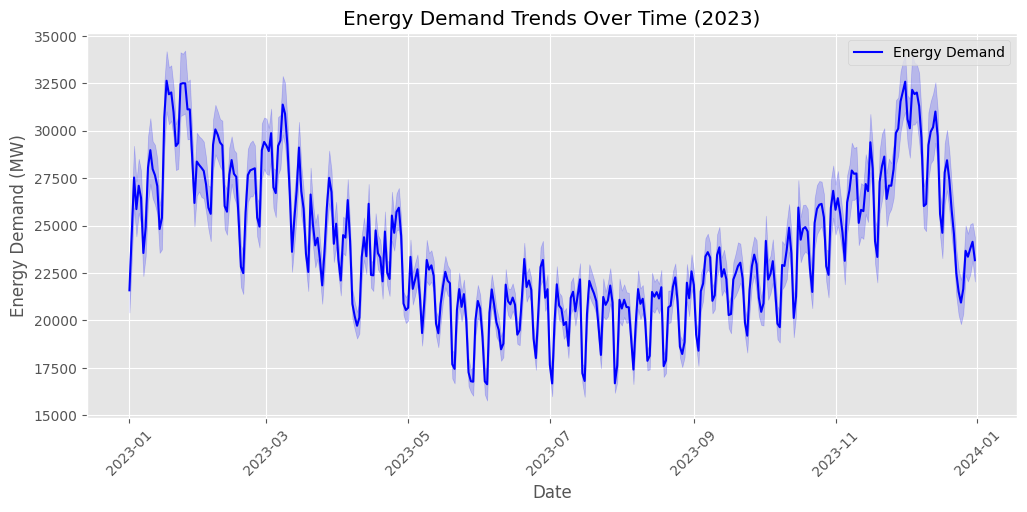

/var/folders/24/8pzn85m10vqgk7r1c979brn00000gn/T/ipykernel_92183/1118988869.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged_2023, x='peak_offpeak', y='england_wales_demand', palette='coolwarm')


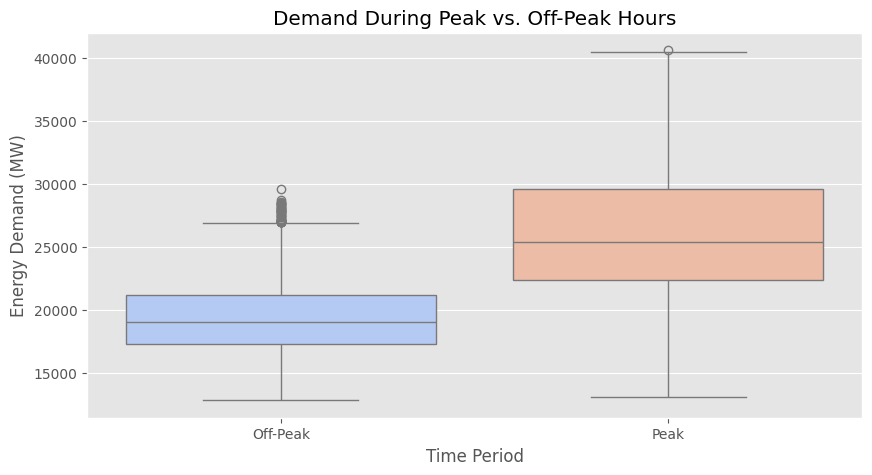

/var/folders/24/8pzn85m10vqgk7r1c979brn00000gn/T/ipykernel_92183/1118988869.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged_2023, x='peak_offpeak', y='daily_price', palette='coolwarm')


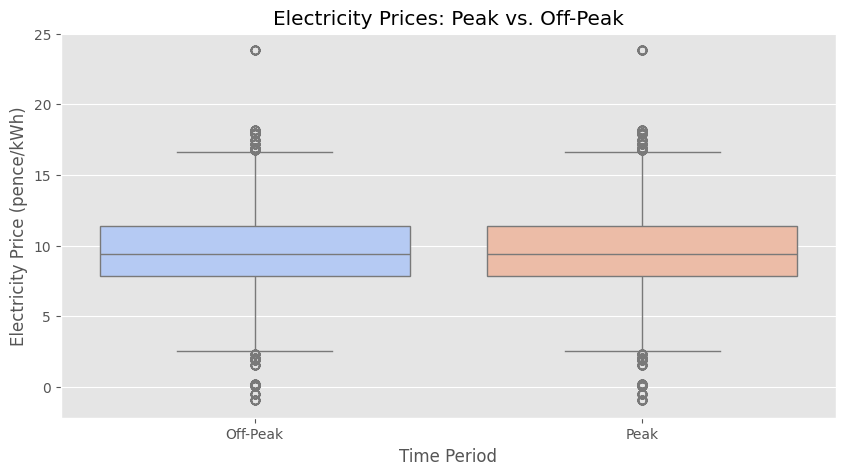

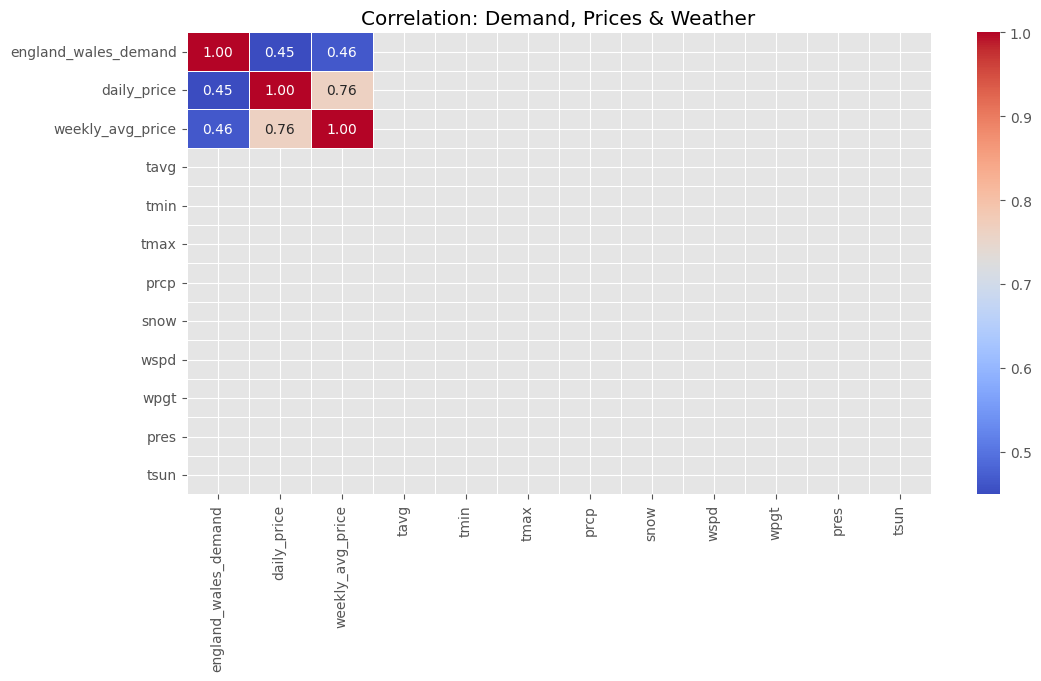

/var/folders/24/8pzn85m10vqgk7r1c979brn00000gn/T/ipykernel_92183/1118988869.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged_2023, x='season', y='england_wales_demand', palette='Set2')


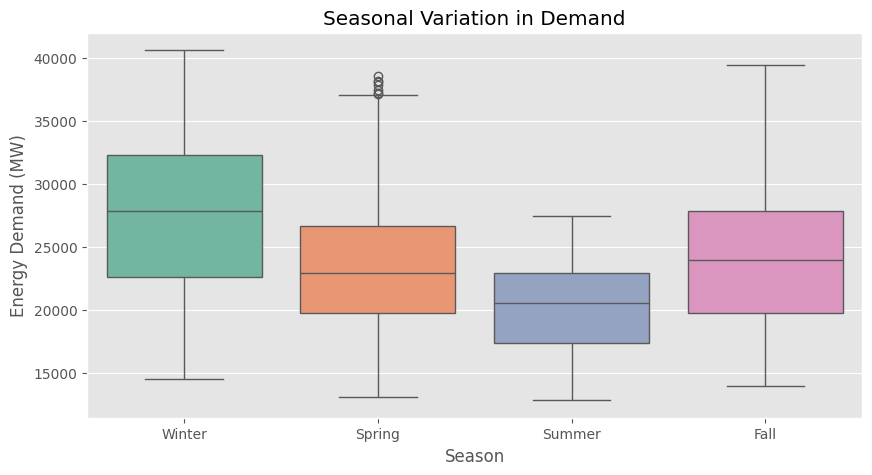

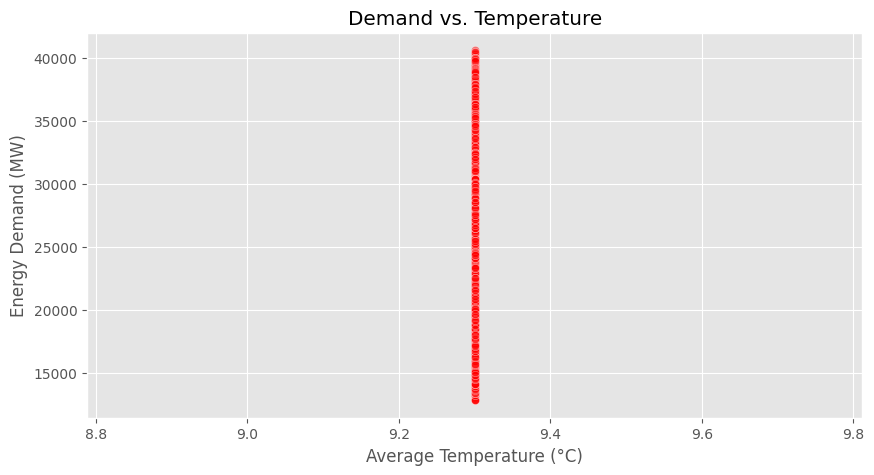

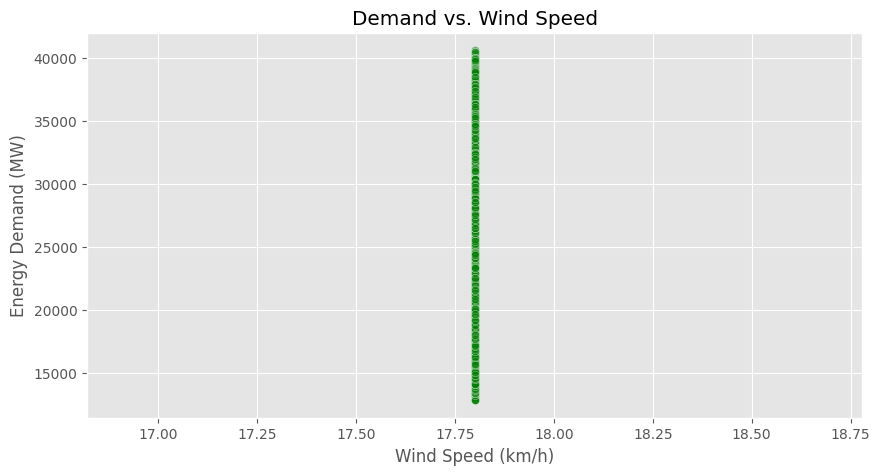

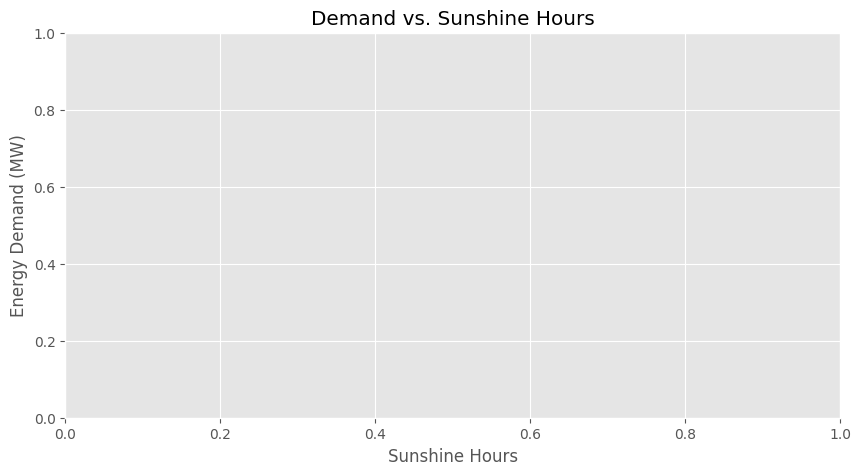

In [6]:
# Set plotting style
plt.style.use('ggplot')

### Demand Trends Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_merged_2023, x='settlement_date', y='england_wales_demand', label='Energy Demand', color='blue')
plt.xlabel('Date')
plt.ylabel('Energy Demand (MW)')
plt.title('Energy Demand Trends Over Time (2023)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Peak vs. Off-Peak Demand & Prices
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_merged_2023, x='peak_offpeak', y='england_wales_demand', palette='coolwarm')
plt.xlabel('Time Period')
plt.ylabel('Energy Demand (MW)')
plt.title('Demand During Peak vs. Off-Peak Hours')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_merged_2023, x='peak_offpeak', y='daily_price', palette='coolwarm')
plt.xlabel('Time Period')
plt.ylabel('Electricity Price (pence/kWh)')
plt.title('Electricity Prices: Peak vs. Off-Peak')
plt.show()

### Correlation Analysis
corr_features = ['england_wales_demand', 'daily_price', 'weekly_avg_price', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'wpgt', 'pres', 'tsun']
corr_matrix = df_merged_2023[corr_features].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation: Demand, Prices & Weather')
plt.show()

### Seasonal Effects
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_merged_2023, x='season', y='england_wales_demand', palette='Set2')
plt.xlabel('Season')
plt.ylabel('Energy Demand (MW)')
plt.title('Seasonal Variation in Demand')
plt.show()

### Impact of Weather on Demand
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_merged_2023, x='tavg', y='england_wales_demand', alpha=0.5, color='red')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Energy Demand (MW)')
plt.title('Demand vs. Temperature')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_merged_2023, x='wspd', y='england_wales_demand', alpha=0.5, color='green')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Energy Demand (MW)')
plt.title('Demand vs. Wind Speed')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_merged_2023, x='tsun', y='england_wales_demand', alpha=0.5, color='gold')
plt.xlabel('Sunshine Hours')
plt.ylabel('Energy Demand (MW)')
plt.title('Demand vs. Sunshine Hours')
plt.show()

## Model Building and Forecasting

We now build forecasting models for energy demand using two algorithms: Random Forest and XGBoost. We define features (including lag variables), split the data into training and test sets, and evaluate model performance using MAE and RMSE.

,Model,MAE,RMSE
0,Random Forest,343.384409,475.008966
1,XGBoost,367.026824,480.315625


/var/folders/24/8pzn85m10vqgk7r1c979brn00000gn/T/ipykernel_92183/3070598494.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="MAE", palette="coolwarm")


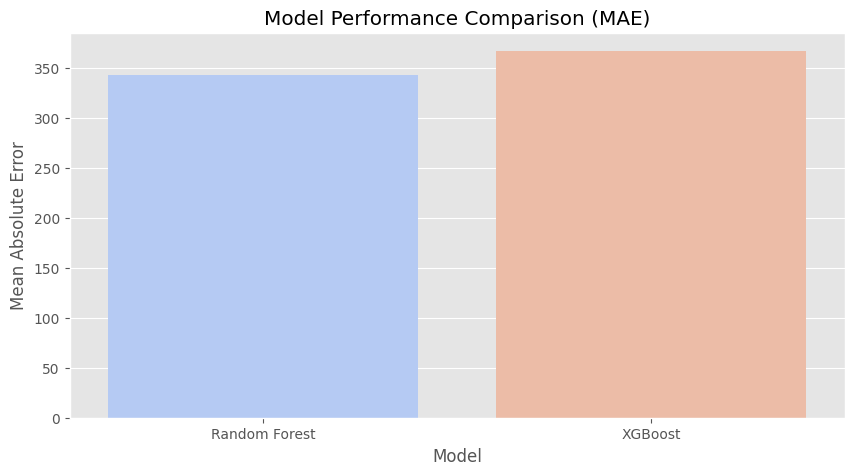

/var/folders/24/8pzn85m10vqgk7r1c979brn00000gn/T/ipykernel_92183/3070598494.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="RMSE", palette="coolwarm")


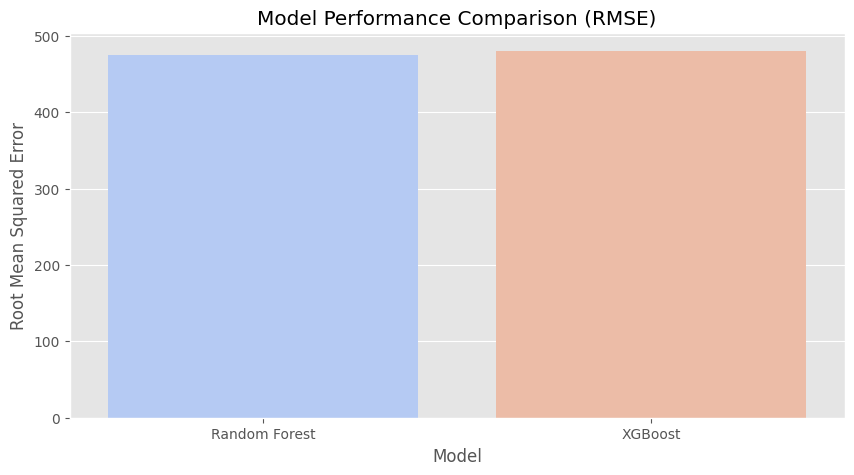

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Create lag features if not already present
for lag in [1, 24, 48]:
    col_name = f"demand_lag_{lag}"
    if col_name not in df_merged_2023.columns:
        df_merged_2023[col_name] = df_merged_2023['england_wales_demand'].shift(lag)

# Drop rows with NaN values from lag features
df_merged_2023.dropna(subset=['demand_lag_48'], inplace=True)

# Define features and target
features = ['hour', 'weekday', 'demand_lag_1', 'demand_lag_24', 'demand_lag_48',
            'tavg', 'wspd', 'prcp', 'daily_price', 'weekly_avg_price']

# (Assuming categorical variables are already encoded or can be added via get_dummies if needed)
target = 'england_wales_demand'

# Fill any remaining missing values
df_merged_2023.fillna(method='bfill', inplace=True)
df_merged_2023.fillna(method='ffill', inplace=True)

# Split data into train and test sets (80/20 split)
train_size = int(len(df_merged_2023) * 0.8)
train, test = df_merged_2023.iloc[:train_size], df_merged_2023.iloc[train_size:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate models
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

# Compile results into a DataFrame
results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [rf_mae, xgb_mae],
    "RMSE": [rf_rmse, xgb_rmse]
})

display(results)

# Visualize performance metrics
plt.figure(figsize=(10, 5))
sns.barplot(data=results, x="Model", y="MAE", palette="coolwarm")
plt.title("Model Performance Comparison (MAE)")
plt.ylabel("Mean Absolute Error")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results, x="Model", y="RMSE", palette="coolwarm")
plt.title("Model Performance Comparison (RMSE)")
plt.ylabel("Root Mean Squared Error")
plt.show()

## Conclusions

In this notebook we integrated multiple datasets to analyze electricity demand, pricing, and weather conditions. After extensive data cleaning and feature engineering, we built and evaluated forecasting models using Random Forest and XGBoost. The evaluation metrics provide insights into model performance, and the visualizations highlight key trends and relationships in the data.

The forecasting models indicate that energy consumption trends are reasonably predictable, with the Random Forest model achieving an average error of ±343 units. This suggests that if the predicted consumption is around 5,000 MW, operators can expect actual demand to fall within a range of roughly 4,657 MW to 5,343 MW on average. While this accuracy supports effective planning and operational decision-making, the observed error margins also underscore the need for maintaining adequate reserves and exploring further model enhancements to capture more variability in energy consumption.

**Next Steps:**

- Further tune the forecasting models and explore additional features or alternative modeling approaches.
- Investigate seasonal and weather-related impacts in more detail to improve forecast accuracy.
- Consider deploying the model in a dashboard for real-time monitoring.

This workflow provides a solid foundation for understanding and forecasting electricity consumption based on a rich set of features.